# Experiment Runner

### Consumes transcoder stream according to the traffic trace and records QoS metrics

In [2]:
import vlc
import os
import time
import pandas as pd
import numpy as np
import requests
import multiprocessing
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [3]:
STREAM_URL = 'http://vimdemo1.cs.upb.de:9000/data/stream_1.m3u8'

class ExperimentClient():
    def __init__(self, url=STREAM_URL):
        stream_url = url
        instance = vlc.Instance("--vout=dummy --aout=dummy".split())
        
        self.media = instance.media_new(stream_url)
        self.player = instance.media_player_new()

        self.player.set_media(self.media)

        self.bitrates = []
        self.playing_time = 0

    def restart_player(self):
        self.player.stop()
        self.player.play()

    def start_player(self):
        self.player.play()

    def stop_player(self):
        self.player.stop()

    def consume_stream_proc(self, timeblock, return_dict):
        _counter = 0
        _just_starting = True
        self.start_player()
        # init_time = time.time()
        previous_bitrate = 0.0
        _same_bitrate_count = 0
        SAME_BITRATE_THRESHOLD = 2
        time.sleep(1)
        while(_counter < timeblock+1):
            try:
                stats = vlc.MediaStats() 
                state = str(self.media.get_state())
                _bitrate = 0.0
                if state in ["State.Opening", "State.Buffering", "State.Playing"]:
                    self.media.get_stats(stats)
                    _bitrate = stats.demux_bitrate*8000.0
                    # print("Bitrate")
                    # print(_bitrate)
                    # print(state)
                    if _bitrate == 0.0:
                        if _just_starting:
                            print("Streaming just started...")
                            _just_starting = False
                        else:
                            print("No data yet...")
                            return_dict['down_time'] += 1
                    else:
                        if _bitrate == previous_bitrate:
                            if _same_bitrate_count >= SAME_BITRATE_THRESHOLD:
                                _same_bitrate_count = 0
                                print("Bitrate seems to be same, stream stuck? - Retrying...")
                                return_dict['down_time'] += SAME_BITRATE_THRESHOLD + 1
                                return_dict['playing_time'] -= SAME_BITRATE_THRESHOLD
                                self.restart_player()
                            else:
                                print("Same bitrate!")
                                _same_bitrate_count += 1
                                return_dict['bitrates'].append(_bitrate)
                                return_dict['playing_time'] += 1
                        else:
                            _same_bitrate_count = 0
                            return_dict['bitrates'].append(_bitrate)
                            return_dict['playing_time'] += 1

                else:
                    if _just_starting:
                        print("Streaming just started...")
                        _just_starting = False                    
                    else:
                        print("Streaming not 'Playing' - Retrying...")
                        return_dict['down_time'] += 1                    
                        self.restart_player()

            except Exception as e:
                print(e)

            print(state, return_dict["bitrates"][-3:], "P:", return_dict["playing_time"], "D:", return_dict["down_time"])
            previous_bitrate = _bitrate
            time.sleep(1)
            _counter += 1

        self.stop_player()        
        return return_dict


In [4]:
MANO_URL = "thesismano1.cs.upb.de"

def set_remote_version(version, host=MANO_URL, port=8898) :
    if "virtual_deployment_units_vm" in version:
        switch_type="VM"
    if "virtual_deployment_units_gpu" in version:
        switch_type="GPU"
    if "virtual_deployment_units_con" in version:
        switch_type="CON"

    _base_path = 'http://{0}:{1}/switch_version?version={2}'.format(host, port, switch_type)

    try:
        r = requests.get(_base_path, verify=False)
        # print("Switch Version")
        print("Switch Version: ", r.text)
    except Exception as e:
        print(e)
        print("Switch version could'nt be set")


## Read Policy Trace

In [5]:
LOOK_AHEAD = 5 # Mins
EXPERIMENT_TIME = 120

traffic_trace_complete = pd.read_csv(r'./data/{}m_policy_decisions_dataset_six_traffic.csv'.format(LOOK_AHEAD), index_col=0)

policy_trace = traffic_trace_complete[['policy']].iloc[:int(EXPERIMENT_TIME/LOOK_AHEAD)]
history_trace = traffic_trace_complete[['history']].iloc[:int(EXPERIMENT_TIME/LOOK_AHEAD)]

print(policy_trace.shape)
policy_trace.head()

(24, 1)


,policy
0,virtual_deployment_units_con:transcoder-image-...
1,virtual_deployment_units_con:transcoder-image-...
2,virtual_deployment_units_con:transcoder-image-...
3,virtual_deployment_units_con:transcoder-image-...
4,virtual_deployment_units_con:transcoder-image-...


# Run Experiments

## 1. Policy Experiment

In [6]:
# TIMEBLOCK = 60
TIMEBLOCK = LOOK_AHEAD * 60

# Setting initial version and waiting
set_remote_version(policy_trace['policy'][0])
time.sleep(30)

for index_label, row_series in policy_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['policy'])

    # Switch version on MANO
    set_remote_version(row_series['policy'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    policy_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    policy_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    policy_trace.at[index_label , 'down_time'] = return_dict["down_time"]

    clear_output(wait=True)


policy_trace.to_csv('./data/{}m_policy_qos_results.csv'.format(LOOK_AHEAD))
policy_trace

,policy,avg_datarate,playing_time,down_time
0,virtual_deployment_units_con:transcoder-image-...,1237.600732,290.0,10.0
1,virtual_deployment_units_con:transcoder-image-...,1763.985117,280.0,20.0
2,virtual_deployment_units_con:transcoder-image-...,1762.379810,276.0,24.0
3,virtual_deployment_units_con:transcoder-image-...,1380.046240,283.0,17.0
4,virtual_deployment_units_con:transcoder-image-...,1642.928476,278.0,22.0
5,virtual_deployment_units_gpu:transcoder-image-...,7189.274181,300.0,0.0
6,virtual_deployment_units_gpu:transcoder-image-...,7010.125609,300.0,0.0
7,virtual_deployment_units_gpu:transcoder-image-...,7176.557132,300.0,0.0
8,virtual_deployment_units_gpu:transcoder-image-...,7264.731001,300.0,0.0
9,virtual_deployment_units_gpu:transcoder-image-...,6015.155286,300.0,0.0


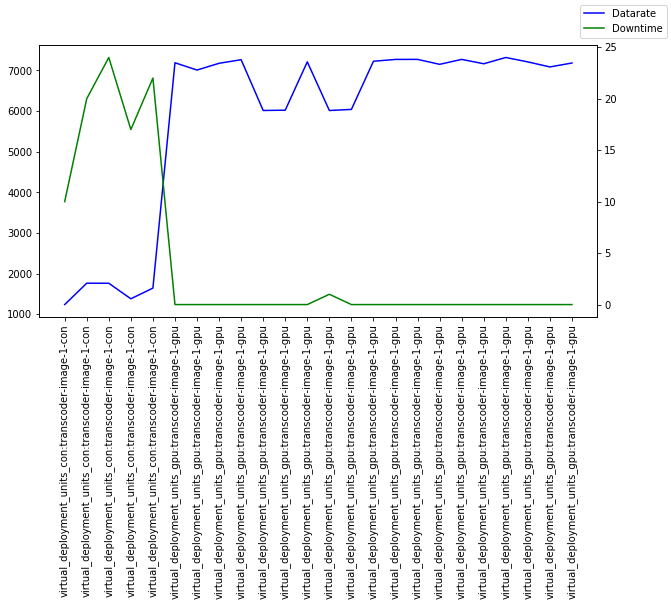

In [7]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = policy_trace.index
y1 = policy_trace['avg_datarate']
y2 = policy_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(policy_trace['policy'])


fig.legend()
# fig = ax2.get_figure()
plt.show()

## 2. History Experiment

In [ ]:
# TIMEBLOCK = 60
TIMEBLOCK = LOOK_AHEAD * 60

# Setting initial version and waiting
set_remote_version(history_trace['history'][0])
time.sleep(30)

for index_label, row_series in history_trace.iterrows():

    print("Running Experiment at: ", index_label, " For: ", row_series['history'])

    # Switch version on MANO
    set_remote_version(row_series['history'])

    manager = multiprocessing.Manager()
    return_dict = manager.dict()

    return_dict["bitrates"] = manager.list()
    return_dict["playing_time"] = 0
    return_dict["down_time"] = 0

    _runner = ExperimentClient()

    p = multiprocessing.Process(target=_runner.consume_stream_proc, args=(TIMEBLOCK, return_dict))
    p.start()

    p.join()

    print("\n####################")
    print(np.mean(return_dict["bitrates"]), return_dict["playing_time"], return_dict["down_time"])
    print("####################\n")

    p.terminate()

    ################
    # Store Results 
    ################
    history_trace.at[index_label , 'avg_datarate'] = np.mean(return_dict["bitrates"])
    history_trace.at[index_label , 'playing_time'] = return_dict["playing_time"]
    history_trace.at[index_label , 'down_time'] = return_dict["down_time"]

    clear_output(wait=True)


history_trace.to_csv('./data/{}m_history_qos_results.csv'.format(LOOK_AHEAD))
history_trace

Running Experiment at:  21  For:  virtual_deployment_units_gpu:transcoder-image-1-gpu
Switch Version:  Done
Streaming just started...
State.Playing [] P: 0 D: 0
State.Playing [3674.4000911712646] P: 1 D: 0
State.Playing [3674.4000911712646, 11839.556694030762] P: 2 D: 0
State.Playing [3674.4000911712646, 11839.556694030762, 2960.2670669555664] P: 3 D: 0
State.Playing [11839.556694030762, 2960.2670669555664, 9417.521476745605] P: 4 D: 0
State.Playing [2960.2670669555664, 9417.521476745605, 5401.280403137207] P: 5 D: 0
Same bitrate!
State.Playing [9417.521476745605, 5401.280403137207, 5401.280403137207] P: 6 D: 0
State.Playing [5401.280403137207, 5401.280403137207, 2461.8430137634277] P: 7 D: 0
State.Playing [5401.280403137207, 2461.8430137634277, 12719.393730163574] P: 8 D: 0
State.Playing [2461.8430137634277, 12719.393730163574, 2005.8021545410156] P: 9 D: 0
Same bitrate!
State.Playing [12719.393730163574, 2005.8021545410156, 2005.8021545410156] P: 10 D: 0
State.Playing [2005.802154541

Same bitrate!
State.Playing [8390.732765197754, 6120.088577270508, 6120.088577270508] P: 95 D: 0
State.Playing [6120.088577270508, 6120.088577270508, 2650.8162021636963] P: 96 D: 0
Same bitrate!
State.Playing [6120.088577270508, 2650.8162021636963, 2650.8162021636963] P: 97 D: 0
State.Playing [2650.8162021636963, 2650.8162021636963, 12896.241188049316] P: 98 D: 0
State.Playing [2650.8162021636963, 12896.241188049316, 1973.327398300171] P: 99 D: 0
State.Playing [12896.241188049316, 1973.327398300171, 5567.017078399658] P: 100 D: 0
State.Playing [1973.327398300171, 5567.017078399658, 10926.004409790039] P: 101 D: 0
State.Playing [5567.017078399658, 10926.004409790039, 3791.2721633911133] P: 102 D: 0
State.Playing [10926.004409790039, 3791.2721633911133, 8255.833625793457] P: 103 D: 0
State.Playing [3791.2721633911133, 8255.833625793457, 6145.126819610596] P: 104 D: 0
Same bitrate!
State.Playing [8255.833625793457, 6145.126819610596, 6145.126819610596] P: 105 D: 0
State.Playing [6145.1268

State.Playing [12597.345352172852, 2340.3210639953613, 9771.862983703613] P: 188 D: 0
Same bitrate!
State.Playing [2340.3210639953613, 9771.862983703613, 9771.862983703613] P: 189 D: 0
State.Playing [9771.862983703613, 9771.862983703613, 2817.4285888671875] P: 190 D: 0
State.Playing [9771.862983703613, 2817.4285888671875, 11768.312454223633] P: 191 D: 0
State.Playing [2817.4285888671875, 11768.312454223633, 3121.2990283966064] P: 192 D: 0
State.Playing [11768.312454223633, 3121.2990283966064, 9047.708511352539] P: 193 D: 0
State.Playing [3121.2990283966064, 9047.708511352539, 969.3369269371033] P: 194 D: 0
State.Playing [9047.708511352539, 969.3369269371033, 11333.60481262207] P: 195 D: 0
State.Playing [969.3369269371033, 11333.60481262207, 3524.01065826416] P: 196 D: 0
State.Playing [11333.60481262207, 3524.01065826416, 8620.892524719238] P: 197 D: 0
State.Playing [3524.01065826416, 8620.892524719238, 6053.879737854004] P: 198 D: 0
Same bitrate!
State.Playing [8620.892524719238, 6053.

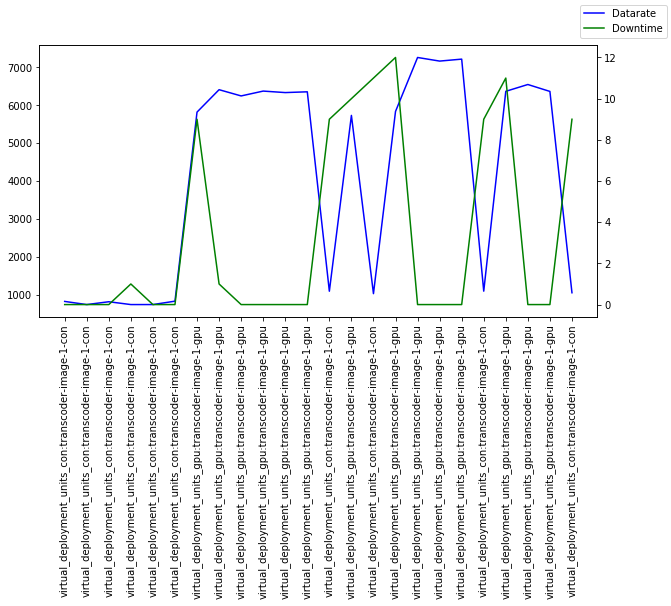

In [10]:
fig, ax1 = plt.subplots(figsize=(10,5))
plt.xticks(rotation=90)

x = history_trace.index
y1 = history_trace['avg_datarate']
y2 = history_trace['down_time']

ax2 = ax1.twinx()

ind = np.arange(len(x))
width = 0.35
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# Bar
# rects1 = ax1.bar(ind - width/2, y1, width, label='Datarate',color = 'b')
# rects2 = ax2.bar(ind + width/2, y2, width, label='Downtime', color = 'g')

# Plot
ax1.plot(x, y1, 'g-', label='Datarate',color = 'b')
ax2.plot(x, y2, 'b-', label='Downtime', color = 'g')

ax1.set_xticks(ind)
ax1.set_xticklabels(history_trace['history'])


fig.legend()
# fig = ax2.get_figure()
plt.show()